In [185]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
from typing import List, Union, Optional, Tuple, Mapping
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [9]:
class LinearRegressionDataGenerator:
    """
    Generator for d-dimensional linear regression datasets where all variables but the
    last are generated from spesified distributions, and the last variable
    is generated from linear equation with noise on the other parameters.
    Used for testing purposes.
    """
    def __init__(self,
        parameter_distributions: List[Union[stats.distributions.rv_discrete, stats.distributions.rv_continuous]],
        true_coefficients: jnp.ndarray,
    ):
        """
        Initialise the generator.
        Args:
            parameter_distributions (List[Union[stats.distributions.rv_discrete, stats.distributions.rv_continuous]]): List of Scipy distribution objects to generate data.
            true_coefficients (jnp.ndarray): Coefficients for the linear regression.
        """
        self.parameter_distributions = parameter_distributions
        self.true_coefficients = true_coefficients
        self.d = true_coefficients.shape[0] + 1

    def generate_data(self, n: int, rng_key: jax.random.PRNGKey = None, noise_mean = 0, noise_std = 1) -> jnp.ndarray:
        """
        Generate the output d-dimensional output.
        Args:
            n (int): Number of datapoints to generate.
            rng_key (Jax RNG key, optional): Random number generator key for Jax. Defaults to None.
            noise_mean: Mean for noise for added noise. Defaults to 0.
            noise_std: Standard deviation for added noise. Defaults to 1.
        Returns:
            jnp.ndarray: The generated output.
        """
        if rng_key is None:
            rng_key = jax.random.PRNGKey(7033170967)
        y_rng, *x_keys = jax.random.split(rng_key, self.d)
        columns = []
        for i, key in enumerate(x_keys):
            func = self.parameter_distributions[i].rvs
            column = func(size=n, random_state=np.random.RandomState(key))
            columns.append(np.array(column))
        x = jnp.stack(columns, axis=1)
        alpha = x @ self.true_coefficients.reshape((-1, 1))
        y = alpha + (noise_mean + noise_std * jax.random.normal(key=y_rng, shape=alpha.shape))
        result = jnp.concatenate((x, y), axis=1)
        return result

In [20]:
parameter_distributions = [
    (stats.distributions.norm(loc=30, scale=10)),
    (stats.distributions.gamma(a=5)),
    (stats.distributions.bernoulli(p=0.7))
]
data_gen = LinearRegressionDataGenerator(
    parameter_distributions=parameter_distributions,
    true_coefficients=jnp.array([3, 5, 100])
)

data = data_gen.generate_data(n=10000, rng_key=jax.random.PRNGKey(42), noise_std=1)

In [21]:
data

DeviceArray([[ 30.223196 ,   5.4817376,   1.       , 219.17816  ],
             [ 46.504883 ,   6.807712 ,   1.       , 273.05762  ],
             [ 23.108473 ,   8.533002 ,   1.       , 211.85828  ],
             ...,
             [ 51.780575 ,   3.5082037,   1.       , 274.99658  ],
             [ 12.932197 ,   3.049074 ,   0.       ,  53.160137 ],
             [ 36.51178  ,   3.1061804,   0.       , 125.25115  ]],            dtype=float32)

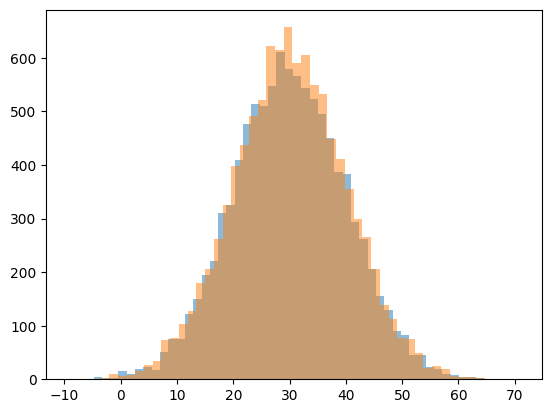

In [11]:
normal_data = stats.distributions.norm.rvs(loc=30, scale=10, size=10000)
plt.hist(data[:,0], bins=50, alpha=0.5)
plt.hist(normal_data, bins=50, alpha=0.5)
plt.show()

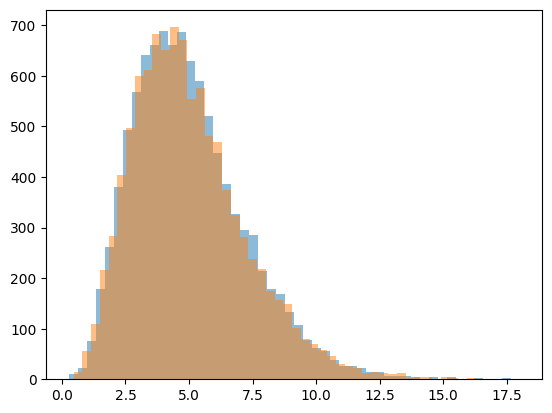

In [12]:
gamma_data = stats.distributions.gamma.rvs(a=5, size=10000)
plt.hist(data[:,1], bins=50, alpha=0.5)
plt.hist(gamma_data, bins=50, alpha=0.5)
plt.show()

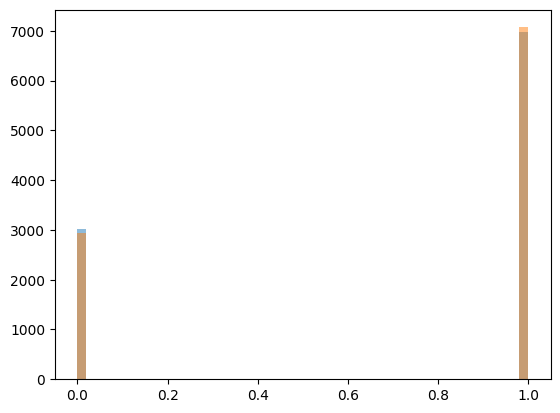

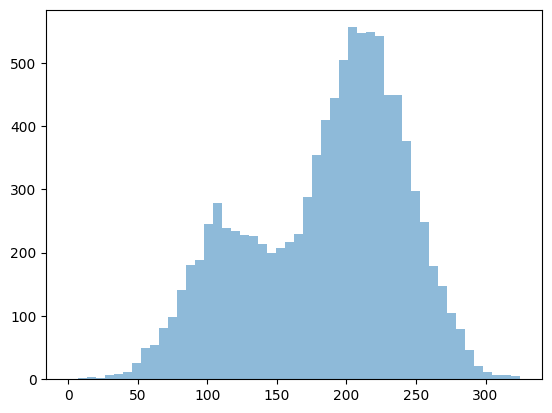

In [13]:
bernoulli_data = stats.distributions.bernoulli.rvs(p=0.7, size=10000)
plt.hist(data[:,2], bins=50, alpha=0.5)
plt.hist(bernoulli_data, bins=50, alpha=0.5)
plt.show()
plt.hist(data[:,3], bins=50, alpha=0.5)
plt.show()

In [14]:
data_np = np.array(data)
model = sm.OLS(data_np[:,-1], data_np[:,:-1]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.264e+08
Date:                Tue, 14 Feb 2023   Prob (F-statistic):                        0.00
Time:                        14:29:14   Log-Likelihood:                         -14107.
No. Observations:               10000   AIC:                                  2.822e+04
Df Residuals:                    9997   BIC:                                  2.824e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9989      0.001   4364.357      0.000       2.998       3.000
x2             5.0060      0.004   1329.289      0.000       4.999       5.013
x3            99.9944      0.020   4970.951      0.000      99.955     100.034
==============================================================================
Omnibus:                        0.321   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.852   Jarque-Bera (JB):                0.311
Skew:                           0.013   Prob(JB):                        0.856
Kurtosis:                       3.005   Cond. No.                         65.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
poisson_d1 = stats.poisson.rvs(mu=1000, size=100000)

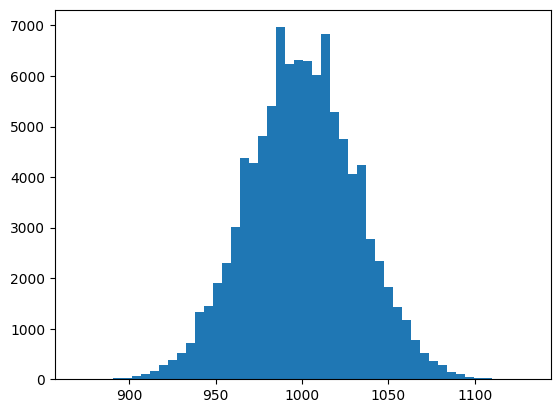

In [99]:
plt.hist(poisson_d1, bins=50)
plt.show()

In [94]:
gamma_d1 = stats.gamma.rvs(a=40, size=10000)

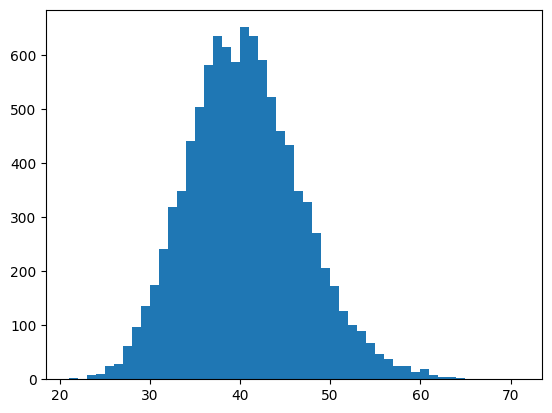

In [97]:
plt.hist(np.round(gamma_d1), bins=50)
plt.show()

In [143]:
classification_data = sklearn.datasets.make_classification(n_samples=10000, n_classes=10, n_clusters_per_class=5, n_features=25, n_informative=15, n_redundant=10, n_repeated=0)
X, y = classification_data

In [144]:
classification_data[0].shape

(10000, 25)

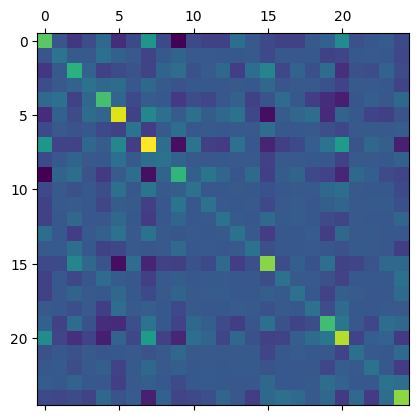

In [145]:
plt.matshow(np.cov(classification_data[0].T))
plt.show()

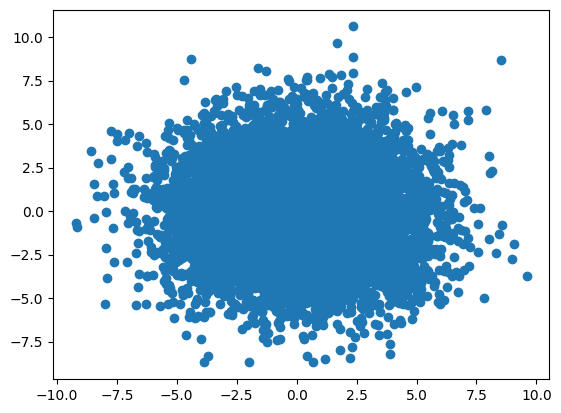

In [157]:
plt.plot(X[:,12], X[:,18], "o")
plt.show()

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [182]:
model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6985
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37865.
Date:                Tue, 14 Feb 2023   Deviance:                       54876.
Time:                        15:15:24   Pearson chi2:                 1.41e+05
No. Iterations:                   100   Pseudo R-squ. (CS):             -260.7
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0072      0.002     -4.172      0.000      -0.011      -0.004
x2             0.0211      0.003      7.447      0.000       0.016       0.027
x3             0.0070      0.002      4.002      0.000       0.004       0.010
x4             0.0048      0.002      1.949      0.051   -2.81e-05       0.010
x5             0.0025      0.002      1.501      0.133      -0.001       0.006
x6             0.0060      0.001      4.091      0.000       0.003       0.009
x7             0.0545      0.002     24.992      0.000       0.050       0.059
x8             0.0330      0.002     21.726      0.000       0.030       0.036
x9             0.0137      0.002      5.968      0.000       0.009       0.018
x10           -0.0076      0.002     -4.332      0.000      -0.011      -0.004
x11            0.0290      0.002     12.693      0.000       0.025       0.033
x12           -0.0112      0.002     -4.559      0.000      -0.016      -0.006
x13            0.0512      0.003     16.797      0.000       0.045       0.057
x14            0.0873      0.002     40.135      0.000       0.083       0.092
x15            0.0476      0.003     18.475      0.000       0.043       0.053
x16            0.0512      0.002     33.226      0.000       0.048       0.054
x17            0.0689      0.002     27.652      0.000       0.064       0.074
x18           -0.0773      0.002    -33.918      0.000      -0.082      -0.073
x19            0.0292      0.002     13.690      0.000       0.025       0.033
x20            0.0146      0.002      8.332      0.000       0.011       0.018
x21           -0.0228      0.002    -14.339      0.000      -0.026      -0.020
x22           -0.0826      0.003    -29.513      0.000      -0.088      -0.077
x23           -0.0316      0.002    -13.149      0.000      -0.036      -0.027
x24            0.1192      0.003     41.371      0.000       0.114       0.125
x25            0.0360      0.001     24.415      0.000       0.033       0.039
==============================================================================
"""

In [184]:
predictions = model.predict(X_test)
print(predictions)
print(accuracy_score(y_test, np.round(predictions)))

[1.0888793  4.90230197 2.69478244 ... 0.2438942  1.08267433 0.62273711]
0.10333333333333333


In [186]:
clf = RandomForestClassifier()

In [187]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [188]:
clf.score(X_test, y_test)

0.5

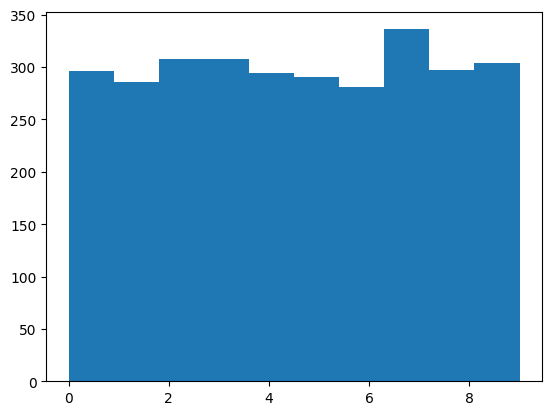

In [192]:
plt.hist(y_test, bins=10)
plt.show()